In [37]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics, layers, models
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
tf.get_logger().setLevel('INFO')

import os
from os import listdir
from PIL import Image


from imblearn.over_sampling import SMOTE
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img

from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

from xgboost import XGBClassifier

from vit_keras import vit, utils

ModuleNotFoundError: No module named 'torch'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [96]:
## Might need to install SMOTE. After install, I needed to close anaconda/jupyter notebook and reopen it for it to
## work :) - Kara
##Also import opencv-python for image augmentation- Negin
# import sys
# !{sys.executable} -m pip install imbalanced-learn
# !{sys.executable} -m pip install opencv-python
# !{sys.executable} -m pip install vit-keras
# !{sys.executable} -m pip install xgboost
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install tensorflow_addons
# !{sys.executable} -m pip install pydot

In [3]:
carrigan = False

### Load Data

In [4]:
if carrigan:
  df = pd.read_csv('/content/drive/MyDrive/Kidney Project Data/kidneyData.csv')
else:
  df = pd.read_csv('KidneyImages/kidneyData.csv')

In [5]:
display(df)

,Unnamed: 0,image_id,path,diag,target,Class
0,0,Tumor- (1044),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
1,1,Tumor- (83),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
2,2,Tumor- (580),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
3,3,Tumor- (1701),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
4,4,Tumor- (1220),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Tumor,3,Tumor
...,...,...,...,...,...,...
12441,12441,Cyst- (2522),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12442,12442,Cyst- (2627),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12443,12443,Cyst- (972),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst
12444,12444,Cyst- (2323),"/content/data/CT KIDNEY DATASET Normal, CYST, ...",Cyst,0,Cyst


In [6]:
newsize = (256, 256)

In [7]:
## Read in all images
# First, read in all cyst images

cystImages = []

# Get the correct folder of images
folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Cyst"

for images in os.listdir(folder_dir): # For each item in the folder
    if (images.endswith(".jpg")): # If it is a jpg
        image = Image.open(folder_dir + '/' + images) # Open the image
        image = image.resize(newsize) # Resize it to 256x256
        npImage = np.asarray(image) # Turn it into an array
        reshapedImage = npImage[:, :, 0] # Get rid of the last two color values (since it is black and white)
        cystImages.append({'image_id': images[:-4], 'image': reshapedImage}) # Add the information to the dictionary

In [8]:
# Then all normal images
normalImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Normal"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        normalImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [9]:
# Then all stone images
stoneImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Stone"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        stoneImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [10]:
# Then all tumor images
tumorImages = []

folder_dir = "KidneyImages/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"
if carrigan:
  folder_dir = "/content/drive/MyDrive/Kidney Project Data/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/CT-KIDNEY-DATASET-Normal-Cyst-Tumor-Stone/Tumor"

for images in os.listdir(folder_dir):
    if (images.endswith(".jpg")):
        image = Image.open(folder_dir + '/' + images)
        image = image.resize(newsize)
        npImage = np.asarray(image)
        reshapedImage = npImage[:, :, 0]

        tumorImages.append({'image_id': images[:-4], 'image': reshapedImage})

In [11]:
# Concatenate all list of images, and turn into a data frame

allImages = cystImages + stoneImages + normalImages + tumorImages

imgs = pd.DataFrame(allImages)

In [12]:
imgs

,image_id,image
0,Cyst- (630),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
1,Cyst- (260),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,Cyst- (1631),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
3,Cyst- (1261),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
4,Cyst- (1774),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
...,...,...
12441,Tumor- (209),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12442,Tumor- (1390),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12443,Tumor- (659),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
12444,Tumor- (1685),"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."


In [13]:
# Make a dictionary of labels
labelDictionary = {0: 'Cyst', 1: 'Normal', 2: 'Stone', 3:'Tumor'}

In [14]:
# Merge with the other dataframe to get each image matched with its label
imgWithLabel = imgs.merge(df, how = 'inner', on = 'image_id')
imgWithLabel = imgWithLabel[['image', 'target']]

In [15]:
X = imgWithLabel['image'].to_numpy()
y = imgWithLabel['target'].to_numpy()

In [ ]:
if carrigan:
  X = np.load('/content/drive/MyDrive/Kidney Project Data/X.npy', allow_pickle=True)
  y = np.load('/content/drive/MyDrive/Kidney Project Data/y.npy', allow_pickle=True)

### Drop Duplicates

In [16]:
# Reshape/ unpack the array of images, then flatten it so it is prepared for smote
X = np.array([x for x in X])
print(X.shape)
nsamples, nx, ny = X.shape
X = X.reshape((nsamples,nx*ny))
print(X.shape)

(12446, 256, 256)
(12446, 65536)


In [17]:
X_and_y = np.column_stack((X, y))
print(X_and_y.shape)

(12446, 65537)


In [18]:
X_and_y = pd.DataFrame(X_and_y)
X_and_y = X_and_y.drop_duplicates()
print(X_and_y.shape)

(11929, 65537)


In [19]:
X = X_and_y.iloc[:,:-1].to_numpy()
y = X_and_y.iloc[:,-1:].to_numpy()
print(X.shape)
print(y.shape)

(11929, 65536)
(11929, 1)


### Perform SMOTE

In [ ]:
# Divide by 255, keep as float32 data
#print(np.max(X))
#X = (X.astype(np.float32) / 255.0).astype(np.float32)
#print(np.max(X))

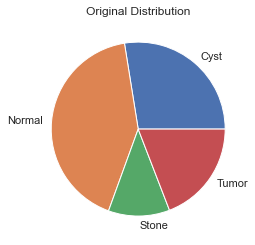

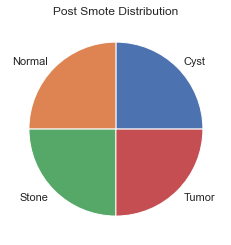

In [20]:
# SMOTE to balance classes

# Original class distribution
unique, counts = np.unique(y, return_counts=True)
uniqueLables = [labelDictionary[x] for x in unique]
plt.pie(counts, labels = uniqueLables)
plt.title('Original Distribution')
plt.show()

# Perform SMOTE sampling
oversample = SMOTE()
Xsmote, ysmote = oversample.fit_resample(X, y)


# Updated class distribution
uniquesmote, countssmote = np.unique(ysmote, return_counts=True)
uniqueLablessmote = [labelDictionary[x] for x in uniquesmote]
plt.pie(countssmote, labels = uniqueLablessmote)
plt.title('Post Smote Distribution')
plt.show()

In [21]:
del X
del y
del X_and_y

### Shuffle & reshape the data

In [22]:
np.random.seed(42)
indices = np.arange(Xsmote.shape[0])
shuffled_indices = np.random.permutation(indices)
Xshuffled = Xsmote[shuffled_indices]
yshuffled = ysmote[shuffled_indices]
print(Xshuffled.shape)

(20008, 65536)


In [23]:
del Xsmote
del ysmote

### Train and test split

In [24]:
X_train_flat, X_test_flat, y_train, y_test = train_test_split(Xshuffled, yshuffled, test_size=0.2, random_state=1)

In [25]:
# Create an intermediary validation set
X_train_flat, X_val_flat, y_train, y_val = train_test_split(X_train_flat, y_train, test_size=0.25, random_state=1)

In [26]:
# Reshape the data to 4 dimensional data
X_train = X_train_flat.reshape((X_train_flat.shape[0],256,256,-1))
X_test = X_test_flat.reshape((X_test_flat.shape[0],256,256,-1))
X_val = X_val_flat.reshape((X_val_flat.shape[0],256,256,-1))

In [27]:
del Xshuffled
del yshuffled

### Image Augmentation

In [34]:
# Create augmentation layers
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
])


(256, 256, 1)


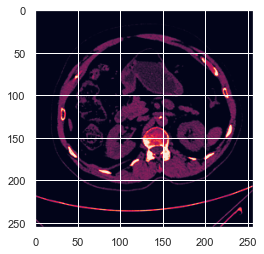

In [35]:
example_image = X_train[2]
print(example_image.shape)

plt.imshow(example_image)

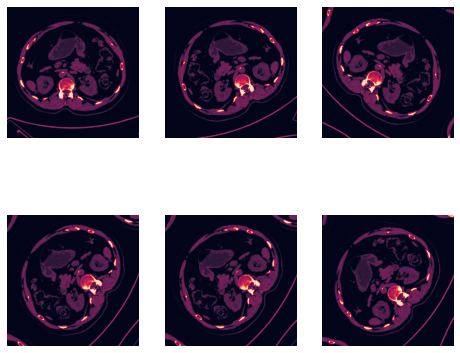

In [36]:
plt.figure(figsize=(8, 7))
for i in range(6):
  aug_image = data_augmentation(example_image)
  ax = plt.subplot(2, 3, i + 1)
  plt.imshow(aug_image.numpy()/255)
  plt.axis("off")

In [45]:
# def rotate_image(image):
#     # Random angle between -20 and 20 degrees
#     angle = np.random.uniform(-20, 20)
#     rotated_image = np.interp(np.arange(len(image)), np.arange(len(image)) + angle, image, left=0, right=0)
#     return rotated_image

# def zoom_image(image):
#     # Random zoom factor between 0.8 and 1.2
#     zoom_factor = np.random.uniform(0.8, 1.2)
#     zoomed_image = np.interp(np.arange(len(image)), np.arange(len(image)) * zoom_factor, image, left=0, right=0)
#     return zoomed_image

# def flip_image(image):
#     # Randomly flip the image horizontally
#     if np.random.rand() > 0.5:
#         flipped_image = np.flip(image)
#     else:
#         flipped_image = image
#     return flipped_image

# def augment_image(image):
#     # Apply rotation
#     rotated_image = rotate_image(image)

#     # Apply zoom
#     zoomed_image = zoom_image(rotated_image)

#     # Apply flip
#     flipped_image = flip_image(zoomed_image)

#     return flipped_image

# # Perform image augmentation on the training data
# X_train_augmented = [augment_image(image) for image in X_train]

# # Convert the augmented data back to NumPy array
# X_train_augmented = np.array(X_train_augmented)

# # Concatenate the original and augmented data
# X_train_combined = np.concatenate((X_train, X_train_augmented))
# y_train_combined = np.concatenate((y_train, y_train.copy()))

# # Ensure X_train_combined and y_train_combined have the correct shapes
# print(X_train_combined.shape)
# print(y_train_combined.shape)



In [ ]:
# X_train = X_train_combined
# y_train = y_train_combined

In [ ]:
# X_train = np.stack(X_train, axis=0)
# Y_train = np.stack(y_train, axis=0)
# X_test = np.stack(X_test, axis=0)
# Y_test = np.stack(y_test, axis=0)

# Create Models

### Model 1 - Multiclass Classifier

In [48]:
def build_multiclass_model(n_classes, learning_rate=0.01):
    """
    Build a multi-class logistic regression model using Keras.

    Args:
    n_classes: Number of classes in the dataset
    learning_rate: The desired learning rate for SGD.

    Returns:
    model: A tf.keras model (graph).
    """

    model = keras.Sequential([
#         data_augmentation,
        keras.layers.Flatten(),
        keras.layers.Dense(units=n_classes, activation="softmax")
    ])

    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    model.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

In [49]:
tf.keras.backend.clear_session()
tf.random.set_seed(0)

model1 = build_multiclass_model(4, 0.01)

history = model1.fit(
  x = X_train,
  y = y_train,
  epochs=5,
  batch_size=128,
  validation_split=0.1,
  verbose=1)

history = pd.DataFrame(history.history)
display(history)

Epoch 1/5
85/85 [==============================] - 4s 40ms/step - loss: 228868.7344 - accuracy: 0.4888 - val_loss: 10613.5879 - val_accuracy: 0.8743
Epoch 2/5
85/85 [==============================] - 3s 39ms/step - loss: 17504.8496 - accuracy: 0.8835 - val_loss: 114725.3438 - val_accuracy: 0.6919
Epoch 3/5
85/85 [==============================] - 3s 36ms/step - loss: 12048.6133 - accuracy: 0.9420 - val_loss: 101.8752 - val_accuracy: 0.9900
Epoch 4/5
85/85 [==============================] - 3s 37ms/step - loss: 193.2870 - accuracy: 0.9933 - val_loss: 32.9669 - val_accuracy: 0.9958
Epoch 5/5
85/85 [==============================] - 3s 36ms/step - loss: 108.9866 - accuracy: 0.9950 - val_loss: 14.8330 - val_accuracy: 0.9992


,loss,accuracy,val_loss,val_accuracy
0,228868.734375,0.488846,10613.587891,0.874271
1,17504.849609,0.883458,114725.343750,0.691923
2,12048.613281,0.941961,101.875214,0.990008
3,193.287003,0.993335,32.966873,0.995837
4,108.986603,0.995001,14.833016,0.999167


In [50]:
test_predictions = np.argmax(model1.predict(X_val), axis=-1)
print(test_predictions)

126/126 [==============================] - 3s 14ms/step
[1 2 3 ... 0 2 2]


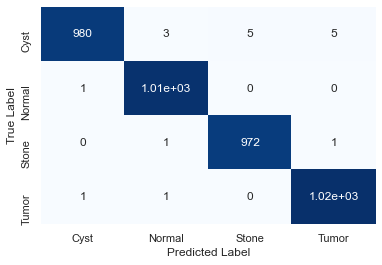

In [51]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(y_val, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=['Cyst','Normal','Stone','Tumor'], yticklabels=['Cyst','Normal','Stone','Tumor'],
                 cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

### Model 2 - Neural Network

In [52]:
def build_model(n_classes,   #should we change the n_classes to 4? since we only have 4 classes
                hidden_layer_sizes=[],
                activation='relu',
                optimizer='SGD',
                learning_rate=0.01):
    tf.keras.backend.clear_session()
    np.random.seed(0)
    tf.random.set_seed(0)
    model = tf.keras.models.Sequential()
    # Flatten the input shape
    model.add(tf.keras.layers.Flatten())
    # Add hidden layers
    for layer_size in hidden_layer_sizes:
        model.add(tf.keras.layers.Dense(layer_size, activation=activation))
    #Add the last neural network layer
    model.add(tf.keras.layers.Dense(units=n_classes, activation='softmax'))
    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")
    return model


Epoch 1/5
169/169 [==============================] - 9s 53ms/step - loss: 251000.8750 - accuracy: 0.2490 - val_loss: 1.3851 - val_accuracy: 0.2348
Epoch 2/5
169/169 [==============================] - 8s 47ms/step - loss: 1.3857 - accuracy: 0.2493 - val_loss: 1.3854 - val_accuracy: 0.2348
Epoch 3/5
169/169 [==============================] - 8s 46ms/step - loss: 1.3855 - accuracy: 0.2497 - val_loss: 1.3855 - val_accuracy: 0.2365
Epoch 4/5
169/169 [==============================] - 8s 46ms/step - loss: 1.3855 - accuracy: 0.2484 - val_loss: 1.3856 - val_accuracy: 0.2365
Epoch 5/5
169/169 [==============================] - 8s 46ms/step - loss: 1.3855 - accuracy: 0.2500 - val_loss: 1.3857 - val_accuracy: 0.2365
126/126 - 1s - loss: 1.3861 - accuracy: 0.2531 - 1s/epoch - 11ms/step


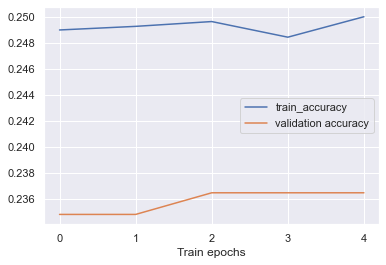

In [59]:
# Build and compile the model
model2_sgd = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', 
                         optimizer='SGD', learning_rate=0.01)

# Train the model for 5 epochs
history = model2_sgd.fit(X_train_flat, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model2_sgd.evaluate(X_val_flat, y_val, verbose=2)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()


Epoch 1/5
169/169 [==============================] - 18s 104ms/step - loss: 4543.1777 - accuracy: 0.4416 - val_loss: 1.1738 - val_accuracy: 0.3813
Epoch 2/5
169/169 [==============================] - 18s 104ms/step - loss: 13.2145 - accuracy: 0.3133 - val_loss: 1.3226 - val_accuracy: 0.2806
Epoch 3/5
169/169 [==============================] - 17s 103ms/step - loss: 22.9598 - accuracy: 0.2931 - val_loss: 1.4406 - val_accuracy: 0.2540
Epoch 4/5
169/169 [==============================] - 18s 105ms/step - loss: 9.8590 - accuracy: 0.2680 - val_loss: 1.3761 - val_accuracy: 0.2664
Epoch 5/5
169/169 [==============================] - 18s 105ms/step - loss: 1.3703 - accuracy: 0.2595 - val_loss: 1.3693 - val_accuracy: 0.2448
126/126 - 3s - loss: 1.3685 - accuracy: 0.2581 - 3s/epoch - 25ms/step


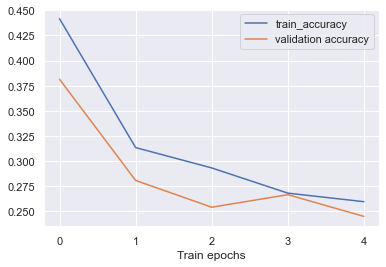

In [60]:
model2_rms = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', 
                         optimizer='RMSprop', learning_rate=0.01)

# Train the model for 5 epochs
history = model2_rms.fit(X_train_flat, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model2_rms.evaluate(X_val_flat, y_val, verbose=2)

train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

Epoch 1/5
169/169 [==============================] - 12s 67ms/step - loss: 1552.7778 - accuracy: 0.3059 - val_loss: 1.3478 - val_accuracy: 0.2873
Epoch 2/5
169/169 [==============================] - 10s 60ms/step - loss: 1.2996 - accuracy: 0.3057 - val_loss: 1.2839 - val_accuracy: 0.3281
Epoch 3/5
169/169 [==============================] - 10s 59ms/step - loss: 1.2621 - accuracy: 0.3271 - val_loss: 1.2871 - val_accuracy: 0.3264
Epoch 4/5
169/169 [==============================] - 10s 59ms/step - loss: 1.2862 - accuracy: 0.3160 - val_loss: 1.2587 - val_accuracy: 0.3422
Epoch 5/5
169/169 [==============================] - 10s 59ms/step - loss: 1.2273 - accuracy: 0.3538 - val_loss: 1.2082 - val_accuracy: 0.3697
126/126 - 2s - loss: 1.2060 - accuracy: 0.3601 - 2s/epoch - 16ms/step


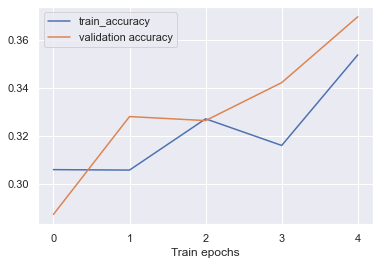

In [61]:
model2_adam = build_model(n_classes=4, hidden_layer_sizes=[128], activation='relu', 
                          optimizer='Adam', learning_rate=0.01)

# Train the model for 5 epochs
history = model2_adam.fit(X_train_flat, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)
test_loss, test_accuracy = model2_adam.evaluate(X_val_flat, y_val, verbose=2)


train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(5))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

### Models 3-4 - CNN

In [62]:
def build_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):

    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Dense layers
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [63]:
input_shape = (32, 32, 3)  # Change this according to your image dimensions

In [64]:
#new_shape = (32, 32, 3)
X_train_reshaped = np.reshape(X_train_flat, (-1, 256, 256, 1))
X_val_reshaped = np.reshape(X_val_flat, (-1, 256, 256, 1))
X_test_reshaped = np.reshape(X_test_flat, (-1, 256, 256, 1))
# Normalize pixel values to range [0, 1]
X_train_reshaped = X_train_reshaped / 255.0
X_val_reshaped = X_val_reshaped / 255.0
X_test_reshaped = X_test_reshaped / 255.0


X_train_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_train_reshaped])
X_val_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_val_reshaped])
X_test_resized = np.array([tf.image.resize(image, (32, 32)) for image in X_test_reshaped])


In [65]:
X_train_rgb = np.repeat(X_train_resized[..., np.newaxis], 3, axis=-1)
X_val_rgb = np.repeat(X_val_resized[..., np.newaxis], 3, axis=-1)
X_test_rgb = np.repeat(X_test_resized[..., np.newaxis], 3, axis=-1)

# Reshape to remove the extra dimension
X_train_rgb = np.squeeze(X_train_rgb, axis=3)
X_val_rgb = np.squeeze(X_val_rgb, axis=3)
X_test_rgb = np.squeeze(X_test_rgb, axis=3)


In [66]:
# Train the CNN model for 5 epochs
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
169/169 [==============================] - 7s 37ms/step - loss: 1.3472 - accuracy: 0.3285 - val_loss: 1.2994 - val_accuracy: 0.4513
Epoch 2/10
169/169 [==============================] - 6s 36ms/step - loss: 1.2103 - accuracy: 0.4972 - val_loss: 1.1142 - val_accuracy: 0.5445
Epoch 3/10
169/169 [==============================] - 6s 35ms/step - loss: 1.0510 - accuracy: 0.5554 - val_loss: 1.0388 - val_accuracy: 0.5529
Epoch 4/10
169/169 [==============================] - 6s 36ms/step - loss: 0.9743 - accuracy: 0.5835 - val_loss: 0.9606 - val_accuracy: 0.5820
Epoch 5/10
169/169 [==============================] - 6s 36ms/step - loss: 0.8924 - accuracy: 0.6180 - val_loss: 0.8494 - val_accuracy: 0.6486
Epoch 6/10
169/169 [==============================] - 6s 36ms/step - loss: 0.8237 - accuracy: 0.6538 - val_loss: 0.7908 - val_accuracy: 0.7269
Epoch 7/10
169/169 [==============================] - 6s 38ms/step - loss: 0.7428 - accuracy: 0.7036 - val_loss: 0.6971 - val_accuracy: 0.7019

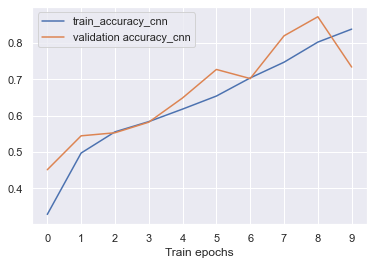

In [67]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [68]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
169/169 [==============================] - 7s 38ms/step - loss: 1.0946 - accuracy: 0.5026 - val_loss: 1.0575 - val_accuracy: 0.5321
Epoch 2/10
169/169 [==============================] - 6s 36ms/step - loss: 0.4420 - accuracy: 0.8186 - val_loss: 0.2522 - val_accuracy: 0.8943
Epoch 3/10
169/169 [==============================] - 6s 36ms/step - loss: 0.1496 - accuracy: 0.9490 - val_loss: 0.3233 - val_accuracy: 0.8984
Epoch 4/10
169/169 [==============================] - 6s 36ms/step - loss: 0.0815 - accuracy: 0.9724 - val_loss: 0.0878 - val_accuracy: 0.9725
Epoch 5/10
169/169 [==============================] - 6s 36ms/step - loss: 0.0525 - accuracy: 0.9833 - val_loss: 0.1287 - val_accuracy: 0.9550
Epoch 6/10
169/169 [==============================] - 6s 36ms/step - loss: 0.0562 - accuracy: 0.9819 - val_loss: 0.0430 - val_accuracy: 0.9858
Epoch 7/10
169/169 [==============================] - 6s 36ms/step - loss: 0.0490 - accuracy: 0.9829 - val_loss: 0.0556 - val_accuracy: 0.9850

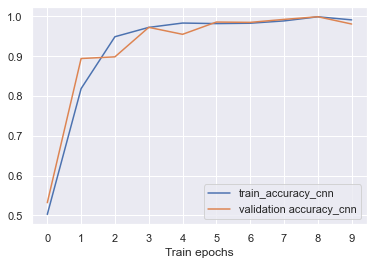

In [69]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [70]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
169/169 [==============================] - 8s 44ms/step - loss: 1.6653 - accuracy: 0.3935 - val_loss: 0.6322 - val_accuracy: 0.7069
Epoch 2/10
169/169 [==============================] - 6s 37ms/step - loss: 0.2860 - accuracy: 0.8975 - val_loss: 1.4946 - val_accuracy: 0.7494
Epoch 3/10
169/169 [==============================] - 6s 36ms/step - loss: 0.1158 - accuracy: 0.9659 - val_loss: 0.0946 - val_accuracy: 0.9659
Epoch 4/10
169/169 [==============================] - 6s 36ms/step - loss: 0.1381 - accuracy: 0.9750 - val_loss: 0.0144 - val_accuracy: 0.9967
Epoch 5/10
169/169 [==============================] - 6s 36ms/step - loss: 0.0799 - accuracy: 0.9816 - val_loss: 0.0062 - val_accuracy: 0.9983
Epoch 6/10
169/169 [==============================] - 6s 36ms/step - loss: 0.0883 - accuracy: 0.9860 - val_loss: 0.0367 - val_accuracy: 0.9908
Epoch 7/10
169/169 [==============================] - 7s 43ms/step - loss: 0.0806 - accuracy: 0.9861 - val_loss: 0.0452 - val_accuracy: 0.9917

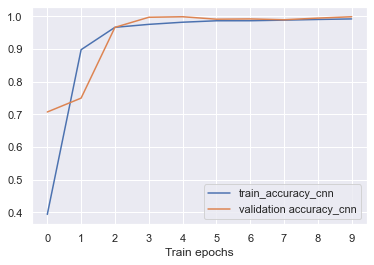

In [71]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [72]:
#building a new CNN model increasing the number of filters

def build_new_cnn_model(input_shape, n_classes, optimizer='SGD', learning_rate=0.01):
    np.random.seed(0)
    tf.random.set_seed(0)

    model = models.Sequential()

    # Convolutional layers
    model.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(256, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    # Adding drop out layers
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))  # Adding dropout for regularization
    model.add(layers.Dense(n_classes, activation='softmax'))

    if optimizer == 'SGD':
        model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'Adam':
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    elif optimizer == 'RMSprop':
        model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
    else:
        raise ValueError("Invalid optimizer. Please choose from ‘SGD’, ‘Adam’, or ‘RMSprop’.")

    return model


In [73]:
cnn_model = build_cnn_model(input_shape, n_classes=4, optimizer='RMSprop', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
169/169 [==============================] - 8s 40ms/step - loss: 2.0836 - accuracy: 0.4137 - val_loss: 0.8536 - val_accuracy: 0.6911
Epoch 2/10
169/169 [==============================] - 6s 38ms/step - loss: 0.4470 - accuracy: 0.8330 - val_loss: 0.0728 - val_accuracy: 0.9808
Epoch 3/10
169/169 [==============================] - 7s 41ms/step - loss: 0.1638 - accuracy: 0.9591 - val_loss: 0.0286 - val_accuracy: 0.9933
Epoch 4/10
169/169 [==============================] - 6s 37ms/step - loss: 0.0920 - accuracy: 0.9741 - val_loss: 0.0080 - val_accuracy: 0.9967
Epoch 5/10
169/169 [==============================] - 6s 37ms/step - loss: 0.0793 - accuracy: 0.9830 - val_loss: 0.1450 - val_accuracy: 0.9684
Epoch 6/10
169/169 [==============================] - 6s 37ms/step - loss: 0.0593 - accuracy: 0.9872 - val_loss: 0.0231 - val_accuracy: 0.9933
Epoch 7/10
169/169 [==============================] - 6s 36ms/step - loss: 0.0620 - accuracy: 0.9875 - val_loss: 0.0452 - val_accuracy: 0.9892

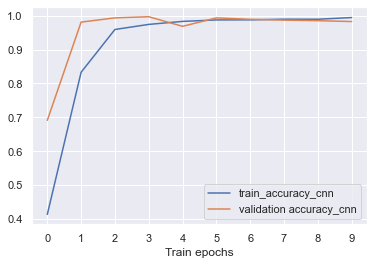

In [74]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [83]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='SGD', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=20, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/20
169/169 [==============================] - 11s 63ms/step - loss: 1.3778 - accuracy: 0.2795 - val_loss: 1.3606 - val_accuracy: 0.3414
Epoch 2/20
169/169 [==============================] - 10s 62ms/step - loss: 1.3442 - accuracy: 0.3474 - val_loss: 1.2965 - val_accuracy: 0.4613
Epoch 3/20
169/169 [==============================] - 11s 62ms/step - loss: 1.2453 - accuracy: 0.4640 - val_loss: 1.1569 - val_accuracy: 0.4646
Epoch 4/20
169/169 [==============================] - 11s 63ms/step - loss: 1.1296 - accuracy: 0.5087 - val_loss: 1.0577 - val_accuracy: 0.5504
Epoch 5/20
169/169 [==============================] - 11s 63ms/step - loss: 1.0635 - accuracy: 0.5319 - val_loss: 1.0115 - val_accuracy: 0.5720
Epoch 6/20
169/169 [==============================] - 11s 63ms/step - loss: 1.0176 - accuracy: 0.5560 - val_loss: 0.9393 - val_accuracy: 0.6062
Epoch 7/20
169/169 [==============================] - 11s 64ms/step - loss: 0.9558 - accuracy: 0.5973 - val_loss: 0.8731 - val_accuracy:

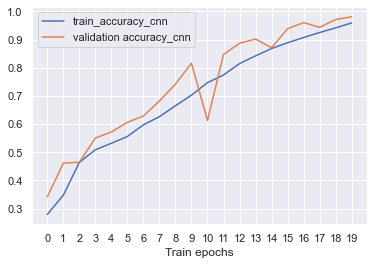

In [84]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(20))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

In [79]:
cnn_model = build_new_cnn_model(input_shape, n_classes=4, optimizer='Adam', learning_rate=0.01)
history_cnn = cnn_model.fit(X_train_rgb, y_train, epochs=10, batch_size=64, validation_split=0.1, verbose=1)
test_loss_cnn, test_accuracy_cnn = cnn_model.evaluate(X_val_rgb, y_val, verbose=2)

Epoch 1/10
169/169 [==============================] - 11s 65ms/step - loss: 1.4601 - accuracy: 0.2517 - val_loss: 1.3866 - val_accuracy: 0.2606
Epoch 2/10
169/169 [==============================] - 11s 64ms/step - loss: 1.3868 - accuracy: 0.2513 - val_loss: 1.3872 - val_accuracy: 0.2348
Epoch 3/10
169/169 [==============================] - 11s 64ms/step - loss: 1.3870 - accuracy: 0.2522 - val_loss: 1.3875 - val_accuracy: 0.2356
Epoch 4/10
169/169 [==============================] - 10s 62ms/step - loss: 1.3871 - accuracy: 0.2471 - val_loss: 1.3861 - val_accuracy: 0.2606
Epoch 5/10
169/169 [==============================] - 11s 63ms/step - loss: 1.3868 - accuracy: 0.2512 - val_loss: 1.3868 - val_accuracy: 0.2348
Epoch 6/10
169/169 [==============================] - 11s 63ms/step - loss: 1.3868 - accuracy: 0.2490 - val_loss: 1.3863 - val_accuracy: 0.2606
Epoch 7/10
169/169 [==============================] - 11s 63ms/step - loss: 1.3868 - accuracy: 0.2488 - val_loss: 1.3897 - val_accuracy:

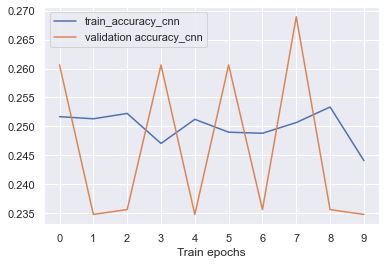

In [80]:
train_accuracy_cnn = history_cnn.history['accuracy']
val_accuracy_cnn = history_cnn.history['val_accuracy']

plt.plot(train_accuracy_cnn, label='train_accuracy_cnn')
plt.plot(val_accuracy_cnn, label='validation accuracy_cnn')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

### Test CNN Model and Create ROC Curve

In [85]:
predictions = cnn_model.predict(X_test_rgb)
class_predictions = np.argmax(predictions, axis=-1)
print(class_predictions)

126/126 [==============================] - 1s 11ms/step
[3 0 1 ... 0 3 2]


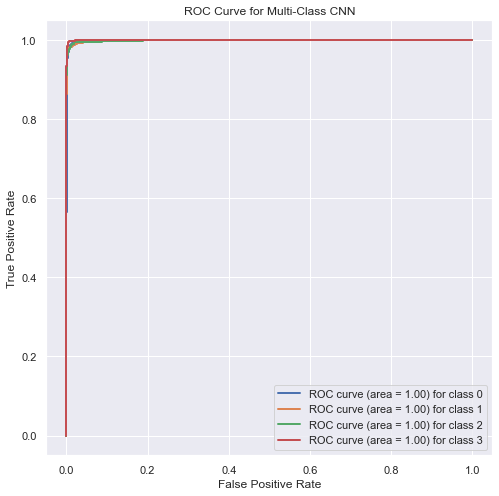

In [86]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

num_classes = np.max(y_test) + 1  # Assuming class indices start from 0
y_test_onehot = label_binarize(y_test, classes=np.arange(num_classes))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:,i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the ROC curve for each class
plt.figure(figsize=(8, 8))
for i in range(4):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (area = {:.2f}) for class {}'.format(roc_auc[i], i))

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class CNN')
plt.legend()
plt.show()

### Model 5 - Transfer Learning

In [87]:
# Should have shape (12004, 256, 256, 1) at start of cell

print(X_train.shape, X_val.shape)
X_train_3_channel = X_train.repeat(3, axis=-1)
X_val_3_channel = X_val.repeat(3, axis = -1)

print(X_train_3_channel.shape, X_val_3_channel.shape)

(12004, 256, 256, 1) (4002, 256, 256, 1)
(12004, 256, 256, 3) (4002, 256, 256, 3)


In [88]:
# Create base model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(256, 256, 3),
    include_top=False)
# Freeze base model
base_model.trainable = False

In [89]:
data_augmentation = keras.Sequential(
    [       keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
               keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ]
)


inputs = keras.Input(shape=(256, 256, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.xception.preprocess_input(x)
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(256, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model4 = keras.Model(inputs, outputs)

model4.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 sequential_9 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 256, 256, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 xception (Functional)       (None, 8, 8, 2048)        20861480  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0     

In [90]:
model4.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model4.fit(X_train_3_channel, y_train, epochs=10, batch_size=64, validation_data = (X_val_3_channel, y_val))

Epoch 1/10
188/188 [==============================] - 804s 4s/step - loss: 0.8722 - accuracy: 0.6217 - val_loss: 0.5952 - val_accuracy: 0.7671
Epoch 2/10
188/188 [==============================] - 786s 4s/step - loss: 0.5294 - accuracy: 0.7945 - val_loss: 0.4552 - val_accuracy: 0.8258
Epoch 3/10
188/188 [==============================] - 794s 4s/step - loss: 0.4379 - accuracy: 0.8334 - val_loss: 0.3928 - val_accuracy: 0.8443
Epoch 4/10
188/188 [==============================] - 785s 4s/step - loss: 0.3689 - accuracy: 0.8595 - val_loss: 0.3392 - val_accuracy: 0.8653
Epoch 5/10
188/188 [==============================] - 781s 4s/step - loss: 0.3185 - accuracy: 0.8820 - val_loss: 0.3782 - val_accuracy: 0.8503
Epoch 6/10
188/188 [==============================] - 781s 4s/step - loss: 0.3041 - accuracy: 0.8833 - val_loss: 0.2092 - val_accuracy: 0.9235
Epoch 7/10
188/188 [==============================] - 783s 4s/step - loss: 0.2631 - accuracy: 0.9030 - val_loss: 0.2437 - val_accuracy: 0.9078

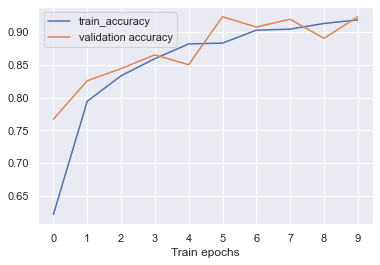

In [91]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()

### Model 6 - KNN

In [92]:
model5 = KNeighborsClassifier(n_neighbors=70, p=2, metric='minkowski')
model5.fit(X_train_flat, y_train)

KNeighborsClassifier(n_neighbors=70)

In [93]:
y_pred = model5.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

error: 0.06271864067966017
Val prediction accuracy: 0.937


In [94]:
y_pred = model5.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

error: 0.07171414292853573
Test prediction accuracy: 0.928


### Model 7 - Decision Tree

In [97]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from six import StringIO
import pydot
from IPython.display import Image, display

In [98]:
# Train a decision tree classifier.
dt = DecisionTreeClassifier(criterion='entropy', min_samples_split=10)
dt.fit(X_train_flat, y_train)
print('Val accuracy:', dt.score(X_val_flat, y_val))
print('Test accuracy:', dt.score(X_test_flat, y_test))

Val accuracy: 0.9810094952523738
Test accuracy: 0.9780109945027486


Output: /Users/karachristensen/MidsWork/207/CarriganNeginKaraFinalProject/iris-decisiontree.jpg


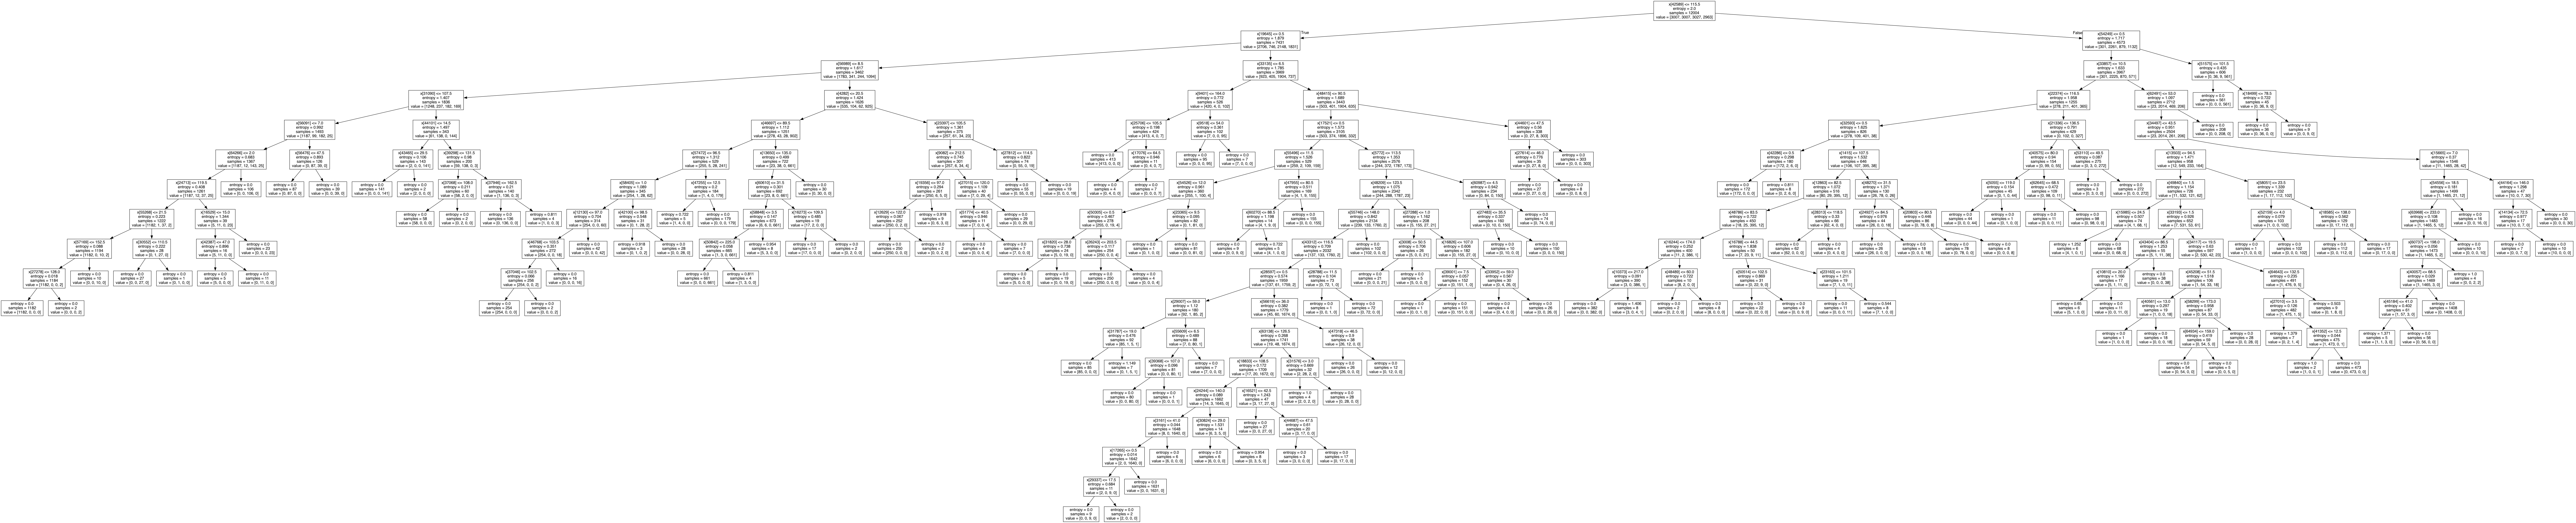

In [99]:
# Export and visualize the trained tree
import os

output_name = 'iris-decisiontree.jpg'
full_path = os.path.join(os.getcwd(), output_name)

dot_data = StringIO()
export_graphviz(dt, out_file=dot_data)
graph = pydot.graph_from_dot_data(dot_data.getvalue())[0]

graph.write_png(output_name)
print('Output:', full_path)
display(Image(filename=full_path))

### Model 8 - Random Forest

In [100]:
if len(X_train.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_train.shape[0]
    X_train = X_train.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact


In [101]:
if len(X_test.shape) > 2:
    # Flatten the input data if it's a multi-dimensional array
    num_samples = X_test.shape[0]
    X_test = X_test.reshape(num_samples, -1)  # Flattening while keeping the first dimension intact

In [102]:
rf_classifier = RandomForestClassifier(n_estimators=4, random_state=42)

# Training the Random Forest classifier
rf_classifier.fit(X_train, y_train)

# Making predictions on the test set
predictions = rf_classifier.predict(X_test)

# Evaluating the model
accuracy = rf_classifier.score(X_test, y_test)
print(f"Random Forest Classifier Accuracy: {accuracy}")

Random Forest Classifier Accuracy: 0.9965017491254373


### Model 9 - XGBoost

In [103]:
model9 = XGBClassifier(tree_method='approx', max_bin=50, n_estimators=5)
model9.fit(X_train_flat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=50,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=5, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [104]:
y_pred = model9.predict(X_val_flat)
error = (y_val != y_pred).sum()/len(y_pred)
print('error:', error)
print('Val prediction accuracy: %.3f'% (1-error))

error: 0.013243378310844578
Val prediction accuracy: 0.987


In [105]:
y_pred = model9.predict(X_test_flat)
error = (y_test != y_pred).sum()/len(y_pred)
print('error:', error)
print('Test prediction accuracy: %.3f'% (1-error))

error: 0.011744127936031985
Test prediction accuracy: 0.988


### Model 10 - ViT (Transfer Learning Vision Transformer)

In [106]:
# Create base model
image_size = 256
basemodel10 = vit.vit_b16(
    image_size=image_size,
    activation='relu',
    pretrained=True,
    include_top=False
    ,pretrained_top=False
#     ,classes=4
)

# Freeze base model
basemodel10.trainable = False

inputs = keras.Input(shape=(256, 256, 3))
x = basemodel10(inputs, training = False)
# x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
x = keras.layers.Dense(128, activation="relu")(x)
outputs = keras.layers.Dense(4, activation= 'softmax')(x)
model10 = keras.Model(inputs, outputs)


model10.summary()

/Users/karachristensen/opt/anaconda3/lib/python3.8/site-packages/vit_keras/utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 16, 16
  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 vit-b16 (Functional)        (None, 768)               85844736  
                                                                 
 dropout_12 (Dropout)        (None, 768)               0         
                                                                 
 dense_27 (Dense)            (None, 128)               98432     
                                                                 
 dense_28 (Dense)            (None, 4)                 516       
                                                                 
Total params: 85,943,684
Trainable params: 98,948
Non-trainable params: 85,844,736
_________________________________________________________________


In [107]:
model10.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model10.fit(X_train_3_channel, y_train, epochs=10, batch_size=64, 
            validation_data = (X_val_3_channel, y_val), verbose = 1)

Epoch 1/10
188/188 [==============================] - 3613s 19s/step - loss: 0.9834 - accuracy: 0.5747 - val_loss: 0.7411 - val_accuracy: 0.7406
Epoch 2/10
188/188 [==============================] - 3618s 19s/step - loss: 0.7214 - accuracy: 0.7223 - val_loss: 0.5914 - val_accuracy: 0.7949
Epoch 3/10
188/188 [==============================] - 3622s 19s/step - loss: 0.6221 - accuracy: 0.7628 - val_loss: 0.5509 - val_accuracy: 0.8051
Epoch 4/10
188/188 [==============================] - 3622s 19s/step - loss: 0.5599 - accuracy: 0.7866 - val_loss: 0.4333 - val_accuracy: 0.8708
Epoch 5/10
188/188 [==============================] - 3615s 19s/step - loss: 0.5061 - accuracy: 0.8056 - val_loss: 0.3566 - val_accuracy: 0.9038
Epoch 6/10
188/188 [==============================] - 3636s 19s/step - loss: 0.4482 - accuracy: 0.8308 - val_loss: 0.3216 - val_accuracy: 0.9055
Epoch 7/10
188/188 [==============================] - 3614s 19s/step - loss: 0.3975 - accuracy: 0.8562 - val_loss: 0.2550 - val_ac

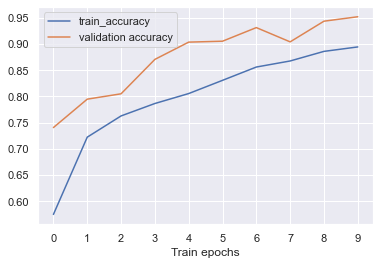

In [108]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
plt.plot(train_accuracy, label='train_accuracy')
plt.plot(val_accuracy, label='validation accuracy')
plt.xticks(range(10))
plt.xlabel('Train epochs')
plt.legend()
plt.show()